In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("data.csv")
df = df.drop(["date",'street','country'],axis = 1)
df = df[df["price"]!= 0]
df = df[df["price"]< 1e7]

y = df["price"]
X = df.drop(["price"],axis = 1)

From observation, we find the “country” feature only have one level, which is “USA”. The “street” feature have different value for every single point. Since those two kind of feature won’t improve the linear model, we removed those. We also removed any price which is 0 or grater than 10000000. We seem price 0 as missing value and seem price greater than 1000000 as outlier.


### Q2.1
Determine which features are continuous vs categorical. Drop rows without a valid sales
price.

In [4]:
print(X.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4549 entries, 0 to 4599
Data columns (total 14 columns):
bedrooms         4549 non-null float64
bathrooms        4549 non-null float64
sqft_living      4549 non-null int64
sqft_lot         4549 non-null int64
floors           4549 non-null float64
waterfront       4549 non-null int64
view             4549 non-null int64
condition        4549 non-null int64
sqft_above       4549 non-null int64
sqft_basement    4549 non-null int64
yr_built         4549 non-null int64
yr_renovated     4549 non-null int64
city             4549 non-null object
statezip         4549 non-null object
dtypes: float64(3), int64(9), object(2)
memory usage: 533.1+ KB
None


In [5]:
cols = X.columns
numeric_cols = X._get_numeric_data().columns

In [6]:
# If numeric feature has level less than 3, view it as a categorical features
cont_col = []
cat_col = list(set(cols) - set(numeric_cols))
for col in numeric_cols:
    if max(list(X[col]))-min(list(X[col]))<3:
        cat_col.append(col)
        X[col] = X[col].astype('category')

    else:
        cont_col.append(col)

In [7]:
cont_col

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'view',
 'condition',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated']

In [8]:
cat_col

['city', 'statezip', 'floors', 'waterfront']

### Q2.2 
Visualize the univariate distribution of each continuous feature, and the distribution of the
target. Do you notice anything? Is there something that might require special treatment?

Text(0.5, 1.0, 'target distribution')

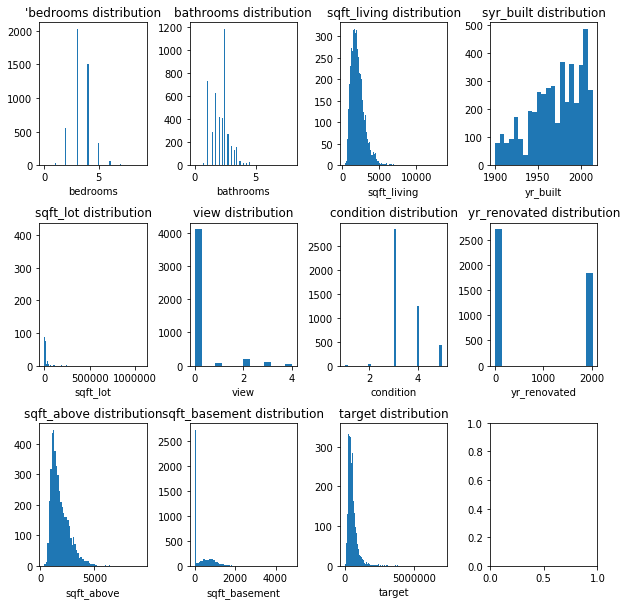

In [9]:
fig,ax = plt.subplots(3,4,figsize = (10,10))

plt.subplots_adjust(hspace = 0.4)
plt.subplots_adjust(wspace = 0.4)

ax[0,0].hist(X['bedrooms'], bins = "auto")
ax[0,0].set_xlabel('bedrooms')
ax[0,0].set_title("'bedrooms distribution")

ax[0,1].hist(X["bathrooms"], bins = "auto")
ax[0,1].set_xlabel("bathrooms")
ax[0,1].set_title("bathrooms distribution")

ax[0,2].hist(X["sqft_living"],bins = "auto")
ax[0,2].set_xlabel('sqft_living')
ax[0,2].set_title("sqft_living distribution")

ax[0,3].hist(X["yr_built"],bins = "auto")
ax[0,3].set_xlabel('yr_built')
ax[0,3].set_title("syr_built distribution")

ax[1,0].hist(X["sqft_lot"],bins = "auto")
ax[1,0].set_xlabel("sqft_lot")
ax[1,0].set_title("sqft_lot distribution")

ax[1,1].hist(X['view'],bins = "auto")
ax[1,1].set_xlabel('view')
ax[1,1].set_title("view distribution")

ax[1,2].hist(X['condition'],bins = "auto")
ax[1,2].set_xlabel('condition')
ax[1,2].set_title("condition distribution")

ax[1,3].hist(X['yr_renovated'],bins = "auto")
ax[1,3].set_xlabel('yr_renovated')
ax[1,3].set_title("yr_renovated distribution")

ax[2,0].hist(X["sqft_above"],bins = "auto")
ax[2,0].set_xlabel("sqft_above")
ax[2,0].set_title("sqft_above distribution")

ax[2,1].hist(X['sqft_basement'],bins = "auto")
ax[2,1].set_xlabel('sqft_basement')
ax[2,1].set_title("sqft_basement distribution")


ax[2,2].hist(y,bins = "auto")
ax[2,2].set_xlabel("target")
ax[2,2].set_title("target distribution")

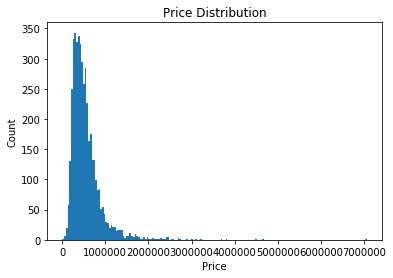

In [10]:
plt.hist(y, bins = 'auto')
plt_price = plt.gca()
plt_price.set_title('Price Distribution')
plt_price.set_xlabel('Price')
plt_price.set_ylabel('Count');

From above we see that there are one or more outlier of price, which make the histogram shrink to left. So we remove price greater than 10^7

We also notice take log value of y would make the histogram not skewed by the log value of y would make the cv score for several model be negative. So here we won’t take the log value of y

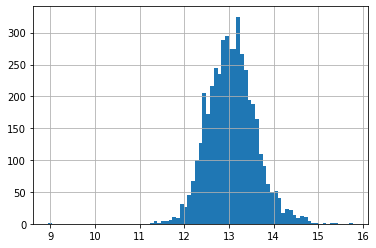

In [11]:
np.log(y).hist(bins = "auto")

### Q2.3
Visualize the dependency of the target on each continuous feature (2d scatter plot).

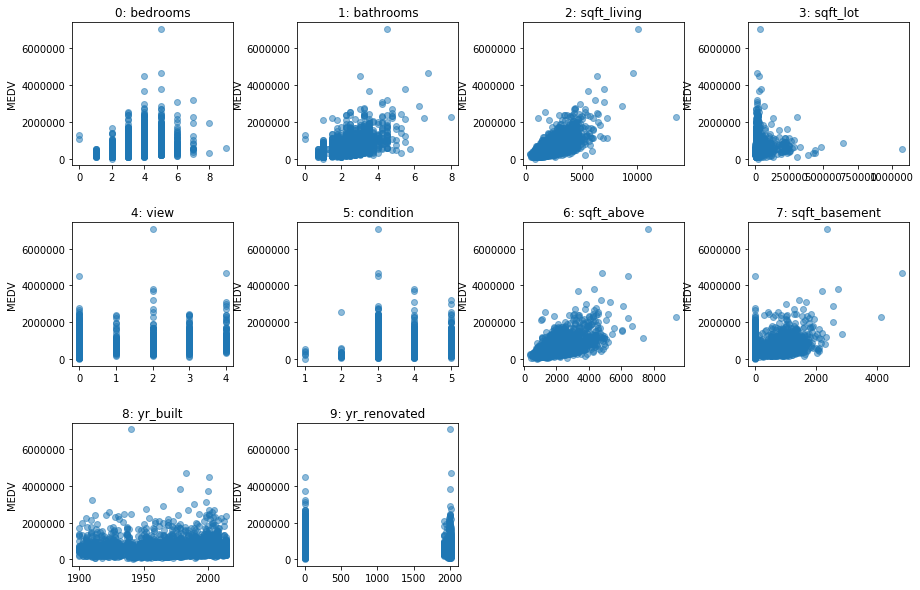

In [12]:
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
plt.subplots_adjust(hspace = 0.4)
plt.subplots_adjust(wspace = 0.4)

for i, ax in enumerate(axes.ravel()):
    if i > 9:
        ax.set_visible(False)
        continue
    ax.plot(X[cont_col].iloc[:, i], y, 'o', alpha=.5)
    ax.set_title("{}: {}".format(i, X[cont_col].columns[i]))
    ax.set_ylabel("MEDV")

Several continuous features have skewed histogram, which need be scaled later

### Q 2.4 
Split data in training and test set. Do not use the test-set unless for a final evaluation in 2.5.
Use ColumnTransformer and pipeline to encode categorical variables (your choice of
OneHotEncoder or another one from the categorical_encoder package, or both). Impute missing
values using SimpleImputer. Evaluate Linear Regression (OLS), Ridge, Lasso and ElasticNet
using cross-validation with the default parameters. Does scaling the data (within the pipeline)
with StandardScaler help? Use the preprocessing that works best going forward.

In [14]:
##split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 0)

cat_preprocessing = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='NA'),
    OneHotEncoder(handle_unknown='ignore'))

cont_preprocessing = make_pipeline(
    SimpleImputer(),
    StandardScaler())

preprocess = make_column_transformer(
    (cat_preprocessing, make_column_selector(dtype_include='object')),
    remainder=cont_preprocessing)
preprocess_non_scale = make_column_transformer(
    (cat_preprocessing, make_column_selector(dtype_include='object')),
    remainder=SimpleImputer())




In [15]:
models = {'OLS': LinearRegression(), 'Ridge': Ridge(), 'Lasso': Lasso(), 'ElasticNet': ElasticNet()}

print("Scaled score")
for model_name, model in models.items():
    model_pipe = make_pipeline(preprocess,model)
    score = cross_val_score(model_pipe, X_train, y_train, cv=10)
    print("The cv score for ",model_name,"is", np.mean(score))
print("Unscaled score")
for model_name, model in models.items():
    model_pipe = make_pipeline(preprocess_non_scale,model)
    score = cross_val_score(model_pipe, X_train, y_train, cv=10)
    print("The cv score for ",model_name,"is", np.mean(score))          


Scaled score
The cv score for  OLS is 0.7278884938749037
The cv score for  Ridge is 0.7302658798085714
The cv score for  Lasso is 0.7279876577406583
The cv score for  ElasticNet is 0.5596089469643468
Unscaled score
The cv score for  OLS is 0.7278051287130395
The cv score for  Ridge is 0.5127624625145787
The cv score for  Lasso is 0.7279896844040017
The cv score for  ElasticNet is 0.5651810042154061


From the result we can see unscaled data has lower score than scaled data for model Ridge. But for other models the score dose not have much difference.

### Q2.5
Tune the parameters of the models using GridSearchCV. Do the results improve? Visualize
the dependence of the validation score on the parameters for Ridge, Lasso and ElasticNet.

In [19]:
model_selection_parameter = {'Ridge': [Ridge(),{'ridge__alpha':np.array([0.001,0.01,0.1,1,10,100])}], 
              'Lasso': [Lasso(),{'lasso__alpha':np.array([0.001,0.01,0.1,1,10,100])}], 
              'ElasticNet': [ElasticNet(),{'elasticnet__alpha':np.array([0.001,0.01,0.1,1,10,100]),
                                           'elasticnet__l1_ratio':np.arange(0, 1, 0.2)}]}
grid = []
                                           
for index, (model, parameter) in enumerate(model_selection_parameter.items()):
    pipe = make_pipeline(preprocess,parameter[0])
    
    grid.append(GridSearchCV(pipe, param_grid = parameter[1], return_train_score = True,cv = 10))
    grid[index].fit(X_train, y_train)
                                           
    print("The train score of {} is {}, parameter is {}".format(model,grid[index].best_score_,
         grid[index].cv_results_['params'][grid[index].best_index_]))   
    
    test_score = grid[index].score(X_test,y_test)
    print("The test score of {} is {}".format(model,test_score))  
    print("########################################")     

The train score of Ridge is 0.7302658798085714, parameter is {'ridge__alpha': 1.0}
The test score of Ridge is 0.7802584182557081
########################################
The train score of Lasso is 0.7298064861200805, parameter is {'lasso__alpha': 100.0}
The test score of Lasso is 0.7806238058054289
########################################
The train score of ElasticNet is 0.7322318355216596, parameter is {'elasticnet__alpha': 0.001, 'elasticnet__l1_ratio': 0.0}
The test score of ElasticNet is 0.7798404367377076
########################################


Obvious the train score after grid search increased

Text(0.5, 1.0, 'Lasso')

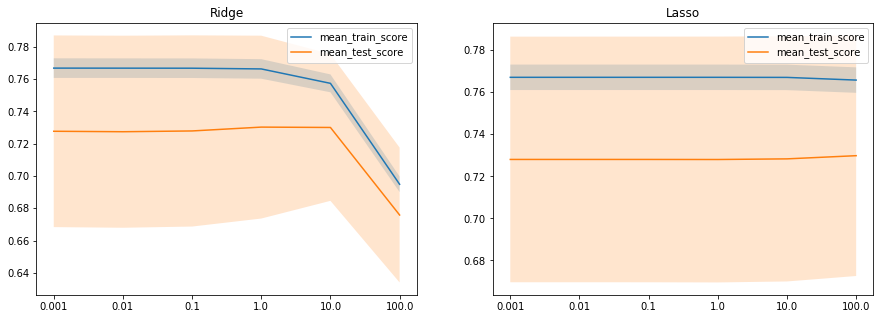

In [26]:
fig,ax = plt.subplots(1,2,figsize = (15,5))

results = pd.DataFrame(grid[0].cv_results_)
x1 = results['param_ridge__alpha']
# create an index for each tick position
xi = list(range(len(x1)))
ax[0].plot(xi, results['mean_train_score'],label = 'mean_train_score')
ax[0].plot(xi,results['mean_test_score'],label = 'mean_test_score')
#ax[0].set_xticks(list(x))

ax[0].fill_between(xi,
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], alpha=0.2)
ax[0].fill_between(xi,
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], alpha=0.2)
ax[0].legend()

plt.sca(ax[0])
plt.xticks(xi,x1)
plt.title("Ridge")

###############################################
results = pd.DataFrame(grid[1].cv_results_)
x2 = results['param_lasso__alpha']
# create an index for each tick position
xi = list(range(len(x2)))
ax[1].plot(xi, results['mean_train_score'],label = 'mean_train_score')
ax[1].plot(xi,results['mean_test_score'],label = 'mean_test_score')

ax[1].fill_between(xi,
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], alpha=0.2)
ax[1].fill_between(xi,
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], alpha=0.2)
ax[1].legend()

plt.sca(ax[1]);
plt.xticks(xi,x2);
plt.title("Lasso")
##############################################


In [28]:
results = pd.DataFrame(grid[2].cv_results_)
results['param_elasticnet__l1_ratio'] = np.round(
    list(results['param_elasticnet__l1_ratio']),1)

t_train = pd.pivot_table(results, 
                         values='mean_train_score', index='param_elasticnet__alpha', 
                         columns='param_elasticnet__l1_ratio')
t_test = pd.pivot_table(results, 
                         values='mean_test_score', index='param_elasticnet__alpha', 
                         columns='param_elasticnet__l1_ratio')

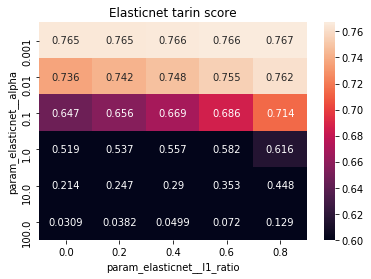

In [29]:
import seaborn as sns
ax = plt.axes()
sns.heatmap(t_train, annot=True, fmt=".3g", vmin=0.6)
ax.set_title('Elasticnet tarin score');
plt.show()


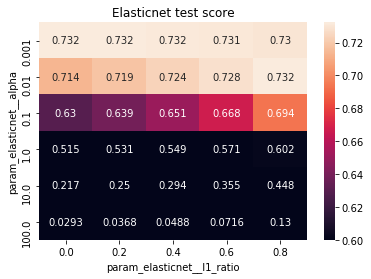

In [30]:
import seaborn as sns
ax = plt.axes()
sns.heatmap(t_test, annot=True, fmt=".3g", vmin=0.6)
ax.set_title('Elasticnet test score')
plt.show()



### Q2.6
Visualize the 20 most important coefficients of the resulting models. Do they agree on which
features are important?

In [31]:
X_dummy = pd.get_dummies(X)

Text(0.5, 1.0, 'Top 20 coefficients for Ridge model')

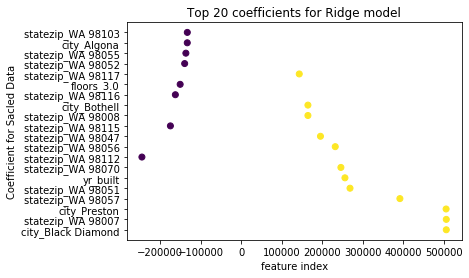

In [32]:
coef = np.abs(grid[0].best_estimator_[1].coef_)
top_coef_idx=list(np.flip(np.argsort(coef)))[:20]

top_coef_name = [list(X_dummy.columns)[i] for i in top_coef_idx]
top_coef = grid[0].best_estimator_[1].coef_[top_coef_idx]

plt.scatter(top_coef,top_coef_name,
            c = np.sign(top_coef))

plt.xlabel('feature index')
plt.ylabel('Coefficient for Sacled Data')
plt.title('Top 20 coefficients for Ridge model')

Text(0.5, 1.0, 'Top 20 coefficients for Lasso model')

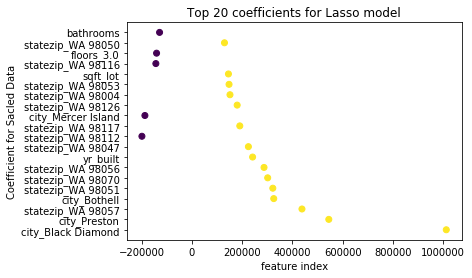

In [33]:
coef = np.abs(grid[1].best_estimator_[1].coef_)
top_coef_idx=list(np.flip(np.argsort(coef)))[:20]

top_coef_name = [list(X_dummy.columns)[i] for i in top_coef_idx]
top_coef = grid[1].best_estimator_[1].coef_[top_coef_idx]

plt.scatter(top_coef,top_coef_name,
            c = np.sign(top_coef))

plt.xlabel('feature index')
plt.ylabel('Coefficient for Sacled Data')
plt.title('Top 20 coefficients for Lasso model')

Text(0.5, 1.0, 'Top 20 coefficients for ElasticNet  model')

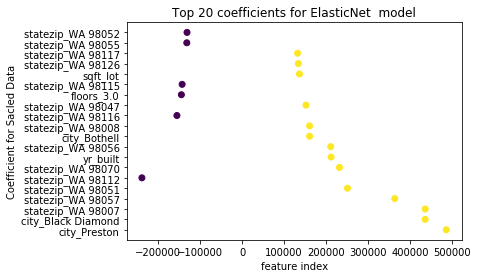

In [34]:
coef = np.abs(grid[2].best_estimator_[1].coef_)
top_coef_idx=list(np.flip(np.argsort(coef)))[:20]

top_coef_name = [list(X_dummy.columns)[i] for i in top_coef_idx]
top_coef = grid[2].best_estimator_[1].coef_[top_coef_idx]

plt.scatter(top_coef,top_coef_name,
            c = np.sign(top_coef))

plt.xlabel('feature index')
plt.ylabel('Coefficient for Sacled Data')
plt.title('Top 20 coefficients for ElasticNet  model')

I agree the features seems resenable. Most of the important featuren are different zipcode and the address is always the most important feature affect house price.